# Introduction

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # To avoid some unnecessary errors that have no effect on our code execution.

df = pd.read_csv('/kaggle/input/math482-2024-2025-1-hw-02-v2/train.csv')

In [2]:
df.head()

id  feature_01  feature_02  feature_03     feature_04  feature_05  \
0   1  262.108596  -89.894193  167.904794 -140202.616462 -402.804373   
1   2  426.918262  -38.046964   67.708543 -179663.370518 -274.514081   
2   3   26.396923  -17.890364   -6.928980   -5232.595711  -28.059078   
3   4   38.882727  145.266810   73.521560   16073.764144 -109.137905   
4   5 -121.406525   -6.326038 -184.656875   -8839.800542   56.735282   

   feature_06  feature_07  feature_08  feature_09  ...    feature_19  \
0  -70.271497  -71.722511  247.294897  -46.345927  ...  30777.337175   
1   85.215962   86.651628   60.284578 -179.844041  ... -14253.863293   
2  169.993086   -2.235779  -41.395950   90.269368  ...  -1864.472190   
3   15.990161   27.174344  329.749882   62.078654  ...  24420.553595   
4   67.911721  -79.757063 -197.434546  314.403055  ... -11489.914208   

   feature_20  feature_21  feature_22  feature_23  feature_24  feature_25  \
0   32.459544   -0.973531   20.972532   35.643581 -266.077043  -30.308368   
1  528.263166    2.318207 -277.914322 -127.031012 -349.114898  -27.902697   
2  492.763499   -1.407389  102.519763  -62.966699  144.731707   71.979399   
3  285.815105    0.655909   33.491158 -125.407409  137.995067   19.900097   
4 -133.541579   -0.449478  206.486620  304.595560   98.408951  -15.239702   

   feature_26  feature_27  target  
0    6.474833  268.632771       0  
1    4.592409    7.762922       0  
2  163.785203   12.363607       0  
3  335.737907  -96.234018       1  
4  -95.526909  113.631796       0  

[5 rows x 29 columns]

# Exploratory Data Analysis

In the exploratory data analysis phase, we focus on understanding the structure and quality of the dataset to prepare it for modeling. First, we need handle the missing values. Next, we identify and handle redundant features by calculating the correlation matrix. Then, we detect highly correlated pairs such as correlation > 0.9. For each pair, we remove one of the features to avoid redundancy and multicollinearity, which can negatively impact model performance. Next, we identify and remove irrelevant features that have no significant relationship with the target variable or display extremely low variance, as these features contribute little to classification. Finally, we check for and handle outliers using visualizations like boxplots or histograms to identify data points that deviate significantly from the rest. Depending on the context, we may choose to cap, transform, or remove these outliers to ensure they do not distort model predictions. This comprehensive analysis ensures that the dataset is clean, relevant, and ready for training robust models.

## Mising Values 

In [3]:
df.isnull().sum()

id              0
feature_01      0
feature_02      0
feature_03      0
feature_04      0
feature_05      0
feature_06      0
feature_07      0
feature_08    350
feature_09    350
feature_10      0
feature_11      0
feature_12      0
feature_13      0
feature_14      0
feature_15      0
feature_16      0
feature_17      0
feature_18      0
feature_19      0
feature_20      0
feature_21    350
feature_22      0
feature_23      0
feature_24      0
feature_25    350
feature_26      0
feature_27      0
target          0
dtype: int64

Columns **feature_08**, **feature_09**, **feature_21**, and **feature_25** have 350 missing values each.

To better assess the importance of these columns, we can calculate the percentage of missing values relative to the total dataset size (number of rows).

In [4]:
total_rows = df.shape[0]
missing_percent = df.isnull().sum() / total_rows * 100
print(missing_percent[missing_percent > 0])

feature_08    1.0
feature_09    1.0
feature_21    1.0
feature_25    1.0
dtype: float64


Since the missing percentage is relatively small which is %1, it is unlikely to have a significant impact on your dataset's quality or the model's performance.

It seems like an easier approach would be to fill the missing values ​​with median and mean. Considering that the percentages are low, there is no problem in trying this approach.

So how do we decide whether to use mean or median?

If the data is symmetric (low skewness): Use the mean because it is a good representation of the central value for normal distributions.

If the data is skewed (high skewness): Use the median because it is less sensitive to extreme values (outliers).

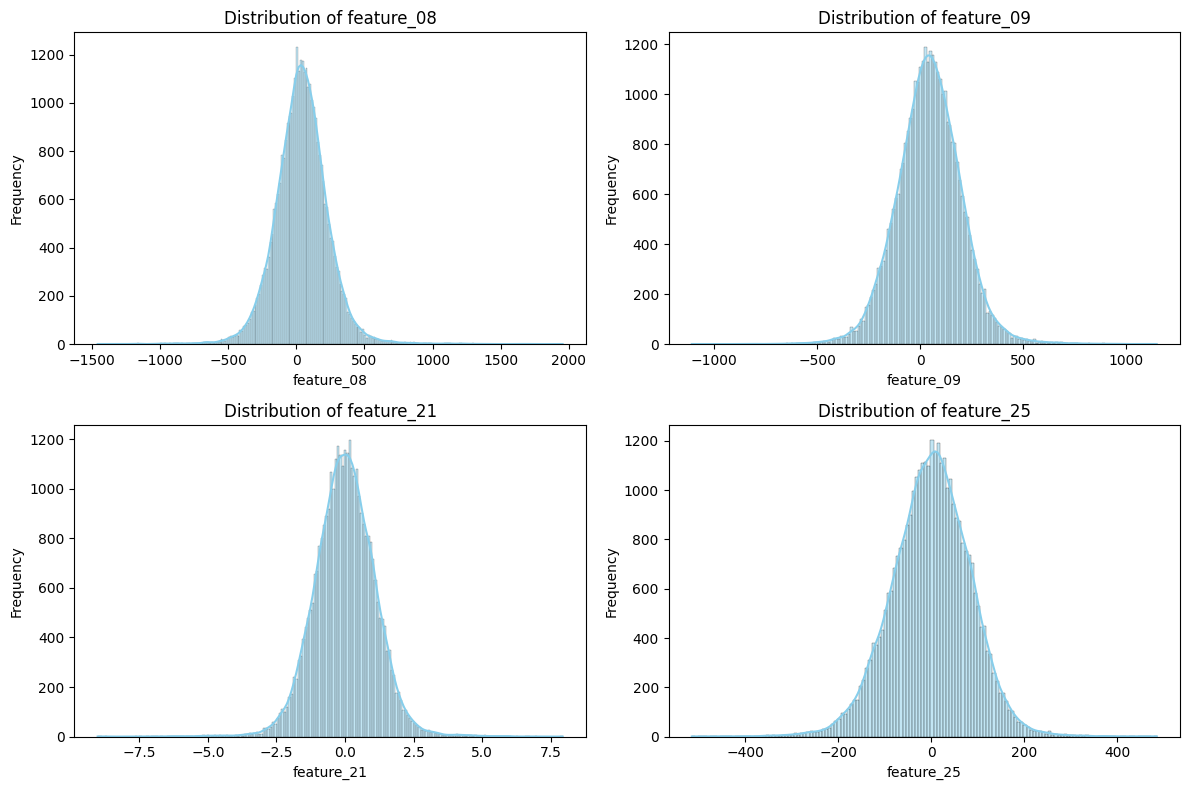

In [5]:
columns_with_missing = ['feature_08', 'feature_09', 'feature_21', 'feature_25']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  
axes = axes.flatten() 

for i, col in enumerate(columns_with_missing):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We can see that these four features have symmetric distributions, so we can fill their missing values with their mean.

In [6]:
columns_with_missing = ['feature_08', 'feature_09', 'feature_21', 'feature_25']

for col in columns_with_missing:
    df[col].fillna(df[col].mean(), inplace=True)

print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 id            0
feature_01    0
feature_02    0
feature_03    0
feature_04    0
feature_05    0
feature_06    0
feature_07    0
feature_08    0
feature_09    0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
target        0
dtype: int64


## Reduntant Features 

To identify and handle reduntant features, we need to compute the pairwise correlation matrix between all features.

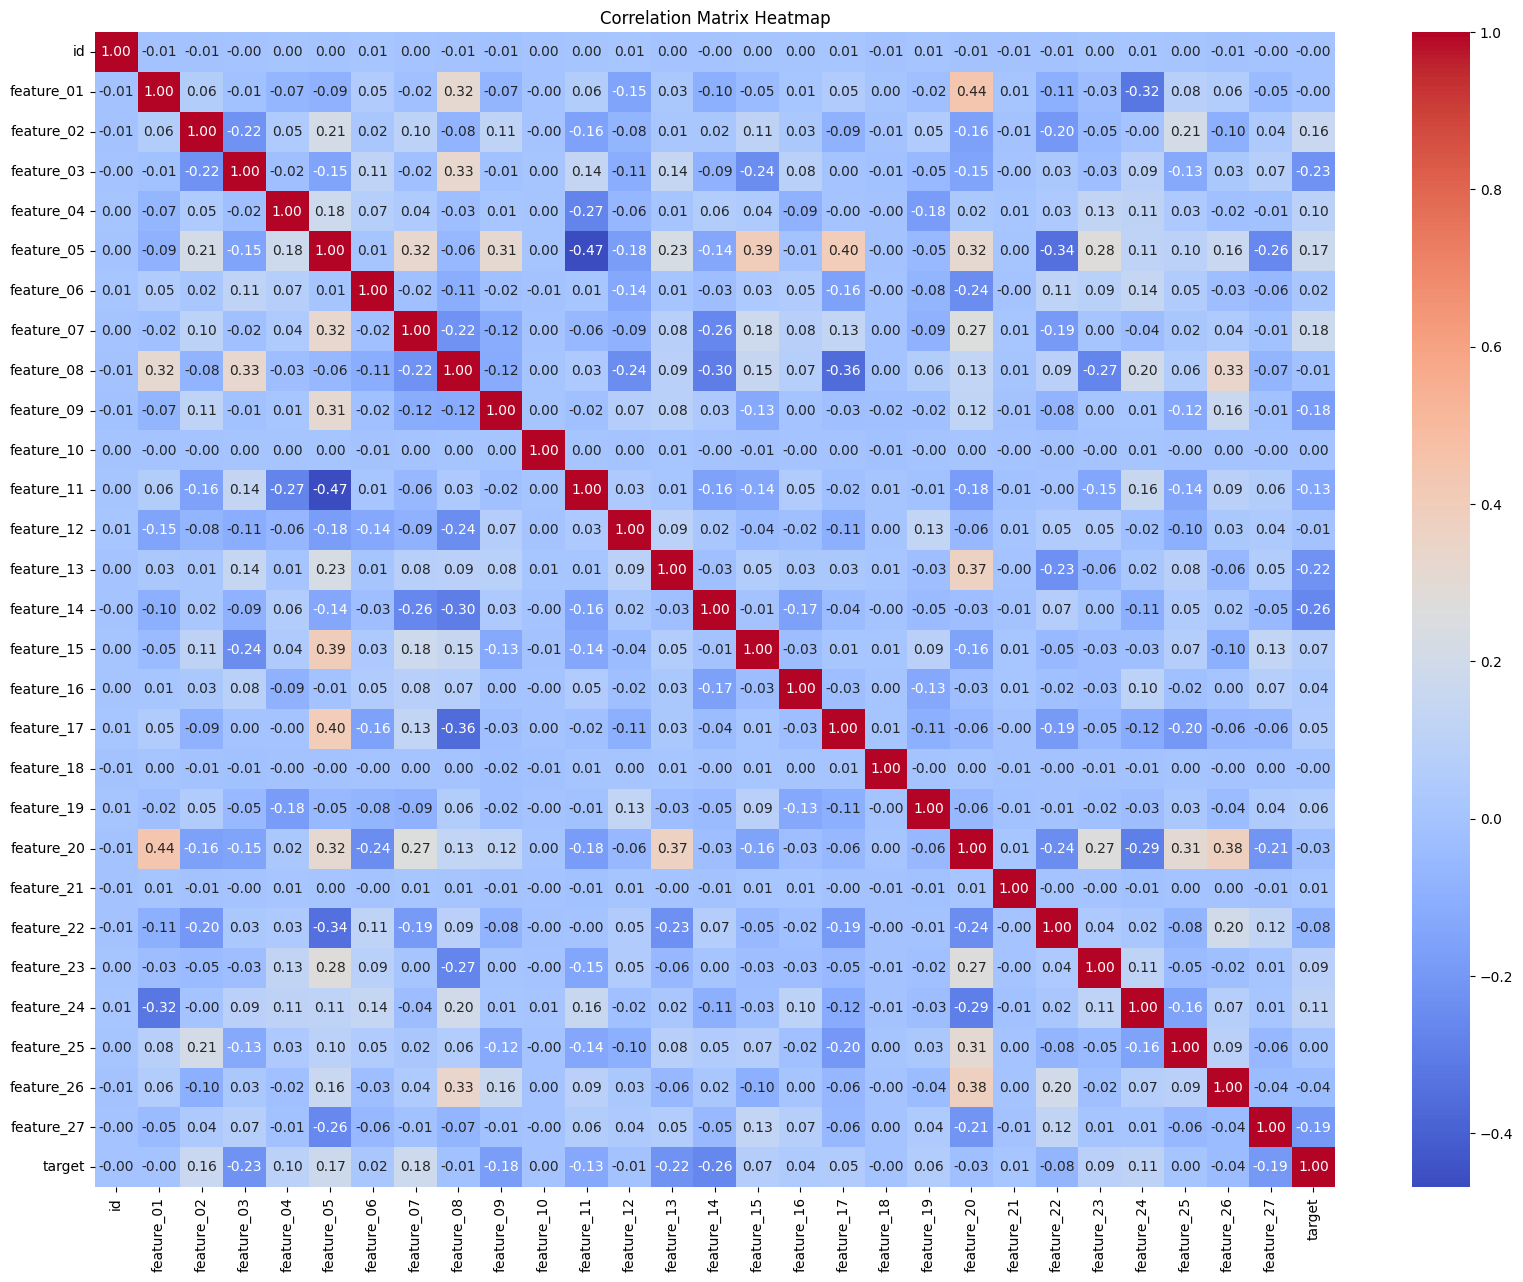

In [7]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

We see that there is no feature that is high correlated with another feature such as correlation > 0.9. However, this is a abstract data set and we do not know  anything about linear relation between the features. Therefore,  we should checht wheter a feature is a linear combination of some other features.

Also, denote that **feature_10**, **feature_18**, and **feature_21** are correlate with other features at most 0.01. 

VIF measures the degree of multicollinearity, with higher values indicating stronger correlation. A common threshold is to consider features with VIF > 10 as problematic, though in this case, we used a stricter threshold (e.g., VIF > 50) to iteratively identify and remove highly correlated features.

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['target']))  

vif_data = pd.DataFrame()
vif_data["Feature"] = df.drop(columns=['target']).columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

       Feature         VIF
0           id    1.001098
1   feature_01   36.366134
2   feature_02   25.475784
3   feature_03   18.933081
4   feature_04    1.184093
5   feature_05   71.016851
6   feature_06   19.010416
7   feature_07   22.885598
8   feature_08   58.345214
9   feature_09    9.999059
10  feature_10    1.000641
11  feature_11   12.829765
12  feature_12    6.674289
13  feature_13   26.636091
14  feature_14   10.033399
15  feature_15   31.074826
16  feature_16    1.094313
17  feature_17   36.010093
18  feature_18    1.001248
19  feature_19    1.135161
20  feature_20  192.982406
21  feature_21    1.001561
22  feature_22    6.677699
23  feature_23   23.706803
24  feature_24   12.099576
25  feature_25    8.312693
26  feature_26   25.019061
27  feature_27    6.592331


It seems that **feature_05**, **feature_08**, **feature_20** have extremely high multicollinearity and are good candidates for removal. 

**feature_01**, **feature_17**, **feature_13**, and **feature_23** are also highly multicollinear, but their importance can be reassessed after removing the extreme VIF features.


In [9]:
clean_df = df.drop(columns = ['feature_05', 'feature_08', 'feature_20'])



scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean_df.drop(columns=['target']))  

vif_data_updated = pd.DataFrame()
vif_data_updated["Feature"] = clean_df.drop(columns=['target']).columns
vif_data_updated["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data_updated)



       Feature       VIF
0           id  1.001067
1   feature_01  1.273288
2   feature_02  1.249245
3   feature_03  1.240425
4   feature_04  1.183184
5   feature_06  1.137553
6   feature_07  1.268605
7   feature_09  1.185176
8   feature_10  1.000364
9   feature_11  1.268076
10  feature_12  1.161188
11  feature_13  1.151361
12  feature_14  1.194830
13  feature_15  1.202239
14  feature_16  1.093764
15  feature_17  1.206766
16  feature_18  1.001095
17  feature_19  1.134481
18  feature_21  1.001331
19  feature_22  1.323650
20  feature_23  1.080906
21  feature_24  1.364395
22  feature_25  1.271309
23  feature_26  1.212059
24  feature_27  1.098667


Based on our updated VIF results, all features now have VIF values below 2, which indicates that the dataset is free of significant multicollinearity. By removing features with extremely high VIF > 50, we have successfully reduced multicollinearity. The remaining features are now independent enough for reliable modeling.

## Irrelevant Features  

In [10]:
correlations = clean_df.corr()["target"].drop("target")
print("Correlations with target:\n", correlations)

# Filter features with low correlation (e.g., |correlation| < 0.01)
low_corr_features = correlations[abs(correlations) < 0.01].index
print("Features with low correlation to the target:", list(low_corr_features))

Correlations with target:
 id           -0.001487
feature_01   -0.001595
feature_02    0.157453
feature_03   -0.227065
feature_04    0.098580
feature_06    0.017889
feature_07    0.180747
feature_09   -0.179974
feature_10    0.000706
feature_11   -0.134184
feature_12   -0.005545
feature_13   -0.217589
feature_14   -0.264548
feature_15    0.065645
feature_16    0.043815
feature_17    0.049576
feature_18   -0.001140
feature_19    0.057688
feature_21    0.009011
feature_22   -0.077902
feature_23    0.092335
feature_24    0.108795
feature_25    0.002693
feature_26   -0.043419
feature_27   -0.194999
Name: target, dtype: float64
Features with low correlation to the target: ['id', 'feature_01', 'feature_10', 'feature_12', 'feature_18', 'feature_21', 'feature_25']


In [11]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(clean_df.drop(columns=["target"]))

low_variance_features = clean_df.drop(columns=["target"]).columns[~selector.get_support()]
print("Features with low variance:", list(low_variance_features))

Features with low variance: []


In [12]:
from sklearn.ensemble import RandomForestClassifier

X = clean_df.drop(columns=["target"])
y = clean_df["target"]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print("Feature importance scores:\n", feature_importance)

low_importance_features = feature_importance[feature_importance["Importance"] < 0.01]["Feature"]
print("Features with low importance:", list(low_importance_features))


Feature importance scores:
        Feature  Importance
15  feature_17    0.085255
24  feature_27    0.057251
12  feature_14    0.053415
11  feature_13    0.049016
7   feature_09    0.048490
9   feature_11    0.048435
20  feature_23    0.047100
3   feature_03    0.046694
19  feature_22    0.045415
2   feature_02    0.044536
1   feature_01    0.044424
6   feature_07    0.042801
10  feature_12    0.042281
23  feature_26    0.041756
21  feature_24    0.041059
5   feature_06    0.040450
13  feature_15    0.040398
22  feature_25    0.038198
14  feature_16    0.029140
17  feature_19    0.027841
4   feature_04    0.026682
0           id    0.015176
16  feature_18    0.014933
8   feature_10    0.014774
18  feature_21    0.014481
Features with low importance: []


We know that **ID** feature has no contrabution to target, and **feature_18**, **feature_10**, **feature_21** are features with low importance than importance of **ID** feature. Also, these features and **feature_1**, **feature_12**, and **feature_25** have less correlation with target. But **feature_1**, **feature_12**, and **feature_25** are features with more high importance than **feature_18**, **feature_10**, **feature_21**. Also, these features have no low varience. Also, remember that in our first correlation matrix, **feature_18**, **feature_10**, **feature_21** are correlated with at most 0.01.  So, it seems that the irrelevant features are these. We need to remove these features. Also, drop the id feature.

In [13]:
df_cleaned = clean_df.drop(columns = ['id','feature_10', 'feature_18', 'feature_21'])
df_cleaned

feature_01  feature_02  feature_03     feature_04  feature_06  \
0      262.108596  -89.894193  167.904794 -140202.616462  -70.271497   
1      426.918262  -38.046964   67.708543 -179663.370518   85.215962   
2       26.396923  -17.890364   -6.928980   -5232.595711  169.993086   
3       38.882727  145.266810   73.521560   16073.764144   15.990161   
4     -121.406525   -6.326038 -184.656875   -8839.800542   67.911721   
...           ...         ...         ...            ...         ...   
34995  -30.982277  160.858038   -3.004035   18703.955304  235.802449   
34996  200.394831  -38.395565  -11.970253  -19155.794409  124.251728   
34997  -41.803240  -11.096508  114.995609  -35356.214360  259.093473   
34998  180.036464  100.624851   28.724963  -64702.740967  118.648912   
34999 -255.018868  -26.634254  -50.733433  -24868.448013  170.456507   

       feature_07  feature_09  feature_11  feature_12  feature_13  ...  \
0      -71.722511  -46.345927  348.178935   -8.624469   17.782590  ...   
1       86.651628 -179.844041  654.389909  -29.107646  249.747628  ...   
2       -2.235779   90.269368  185.965922 -144.560926  184.548711  ...   
3       27.174344   62.078654 -147.209919   -1.180257  -40.847273  ...   
4      -79.757063  314.403055 -155.754327   31.515692 -255.324007  ...   
...           ...         ...         ...         ...         ...  ...   
34995  -15.857158   44.721953 -245.091260  -54.923651 -121.088797  ...   
34996   53.045065 -198.502522   61.319742    4.684779 -211.384640  ...   
34997  -57.516301   36.878197  202.571122  -58.640529  132.617951  ...   
34998   48.725999  -30.098856  200.219529   -1.118573  -60.606199  ...   
34999    3.350093 -234.358984  276.712908  -79.454245   18.022126  ...   

        feature_16  feature_17    feature_19  feature_22  feature_23  \
0      1077.206161  -76.409614  30777.337175   20.972532   35.643581   
1      -355.926191   52.045567 -14253.863293 -277.914322 -127.031012   
2       291.412674   66.303003  -1864.472190  102.519763  -62.966699   
3     -3973.125762 -223.521324  24420.553595   33.491158 -125.407409   
4       858.167161 -202.511567 -11489.914208  206.486620  304.595560   
...            ...         ...           ...         ...         ...   
34995 -2383.618742 -100.283462   7659.274084   13.282155  155.015405   
34996  6509.278156 -147.865859  46108.014012   56.211115   10.123346   
34997  1270.808005   -5.245294    876.401047   52.842315  -92.204274   
34998  1868.768889 -121.346758  39262.728038   -2.943266  -41.633400   
34999  2230.179132 -105.451858   9489.778921 -114.899730  -57.644660   

       feature_24  feature_25  feature_26  feature_27  target  
0     -266.077043  -30.308368    6.474833  268.632771       0  
1     -349.114898  -27.902697    4.592409    7.762922       0  
2      144.731707   71.979399  163.785203   12.363607       0  
3      137.995067   19.900097  335.737907  -96.234018       1  
4       98.408951  -15.239702  -95.526909  113.631796       0  
...           ...         ...         ...         ...     ...  
34995 -125.627600   14.863448  -84.214878   23.677131       0  
34996  488.316937  -28.120023  102.624099  -88.040936       3  
34997   73.130302   71.489930   40.856904   77.727712       0  
34998 -128.442606   52.914212   96.037060    4.929937       0  
34999   98.524786   46.517660   98.266796   60.542431       3  

[35000 rows x 22 columns]

## Outlier Detection 

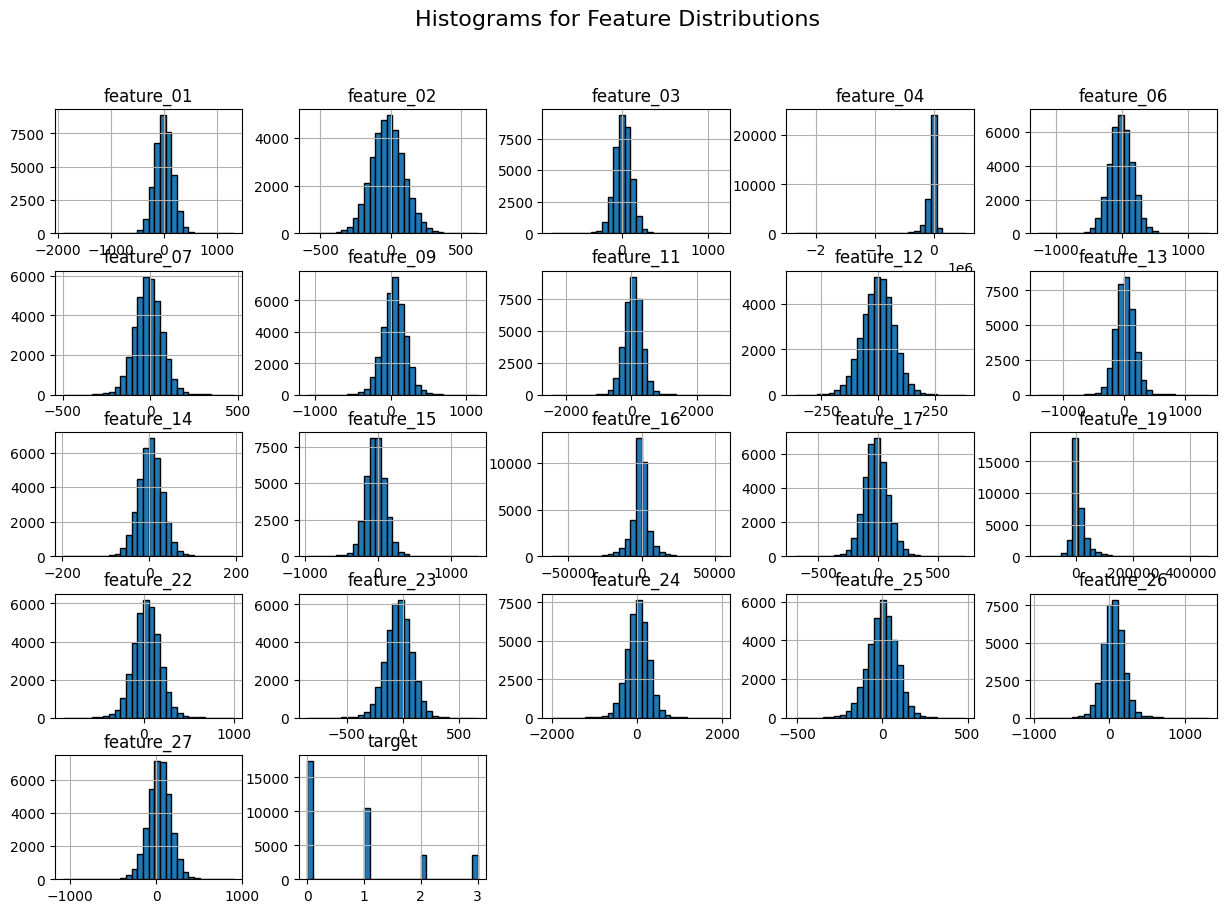

In [14]:
df_cleaned.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms for Feature Distributions", fontsize=16)
plt.show()


Most of the histograms follow a normal distribution, but there is very little data visible towards the extreme values.

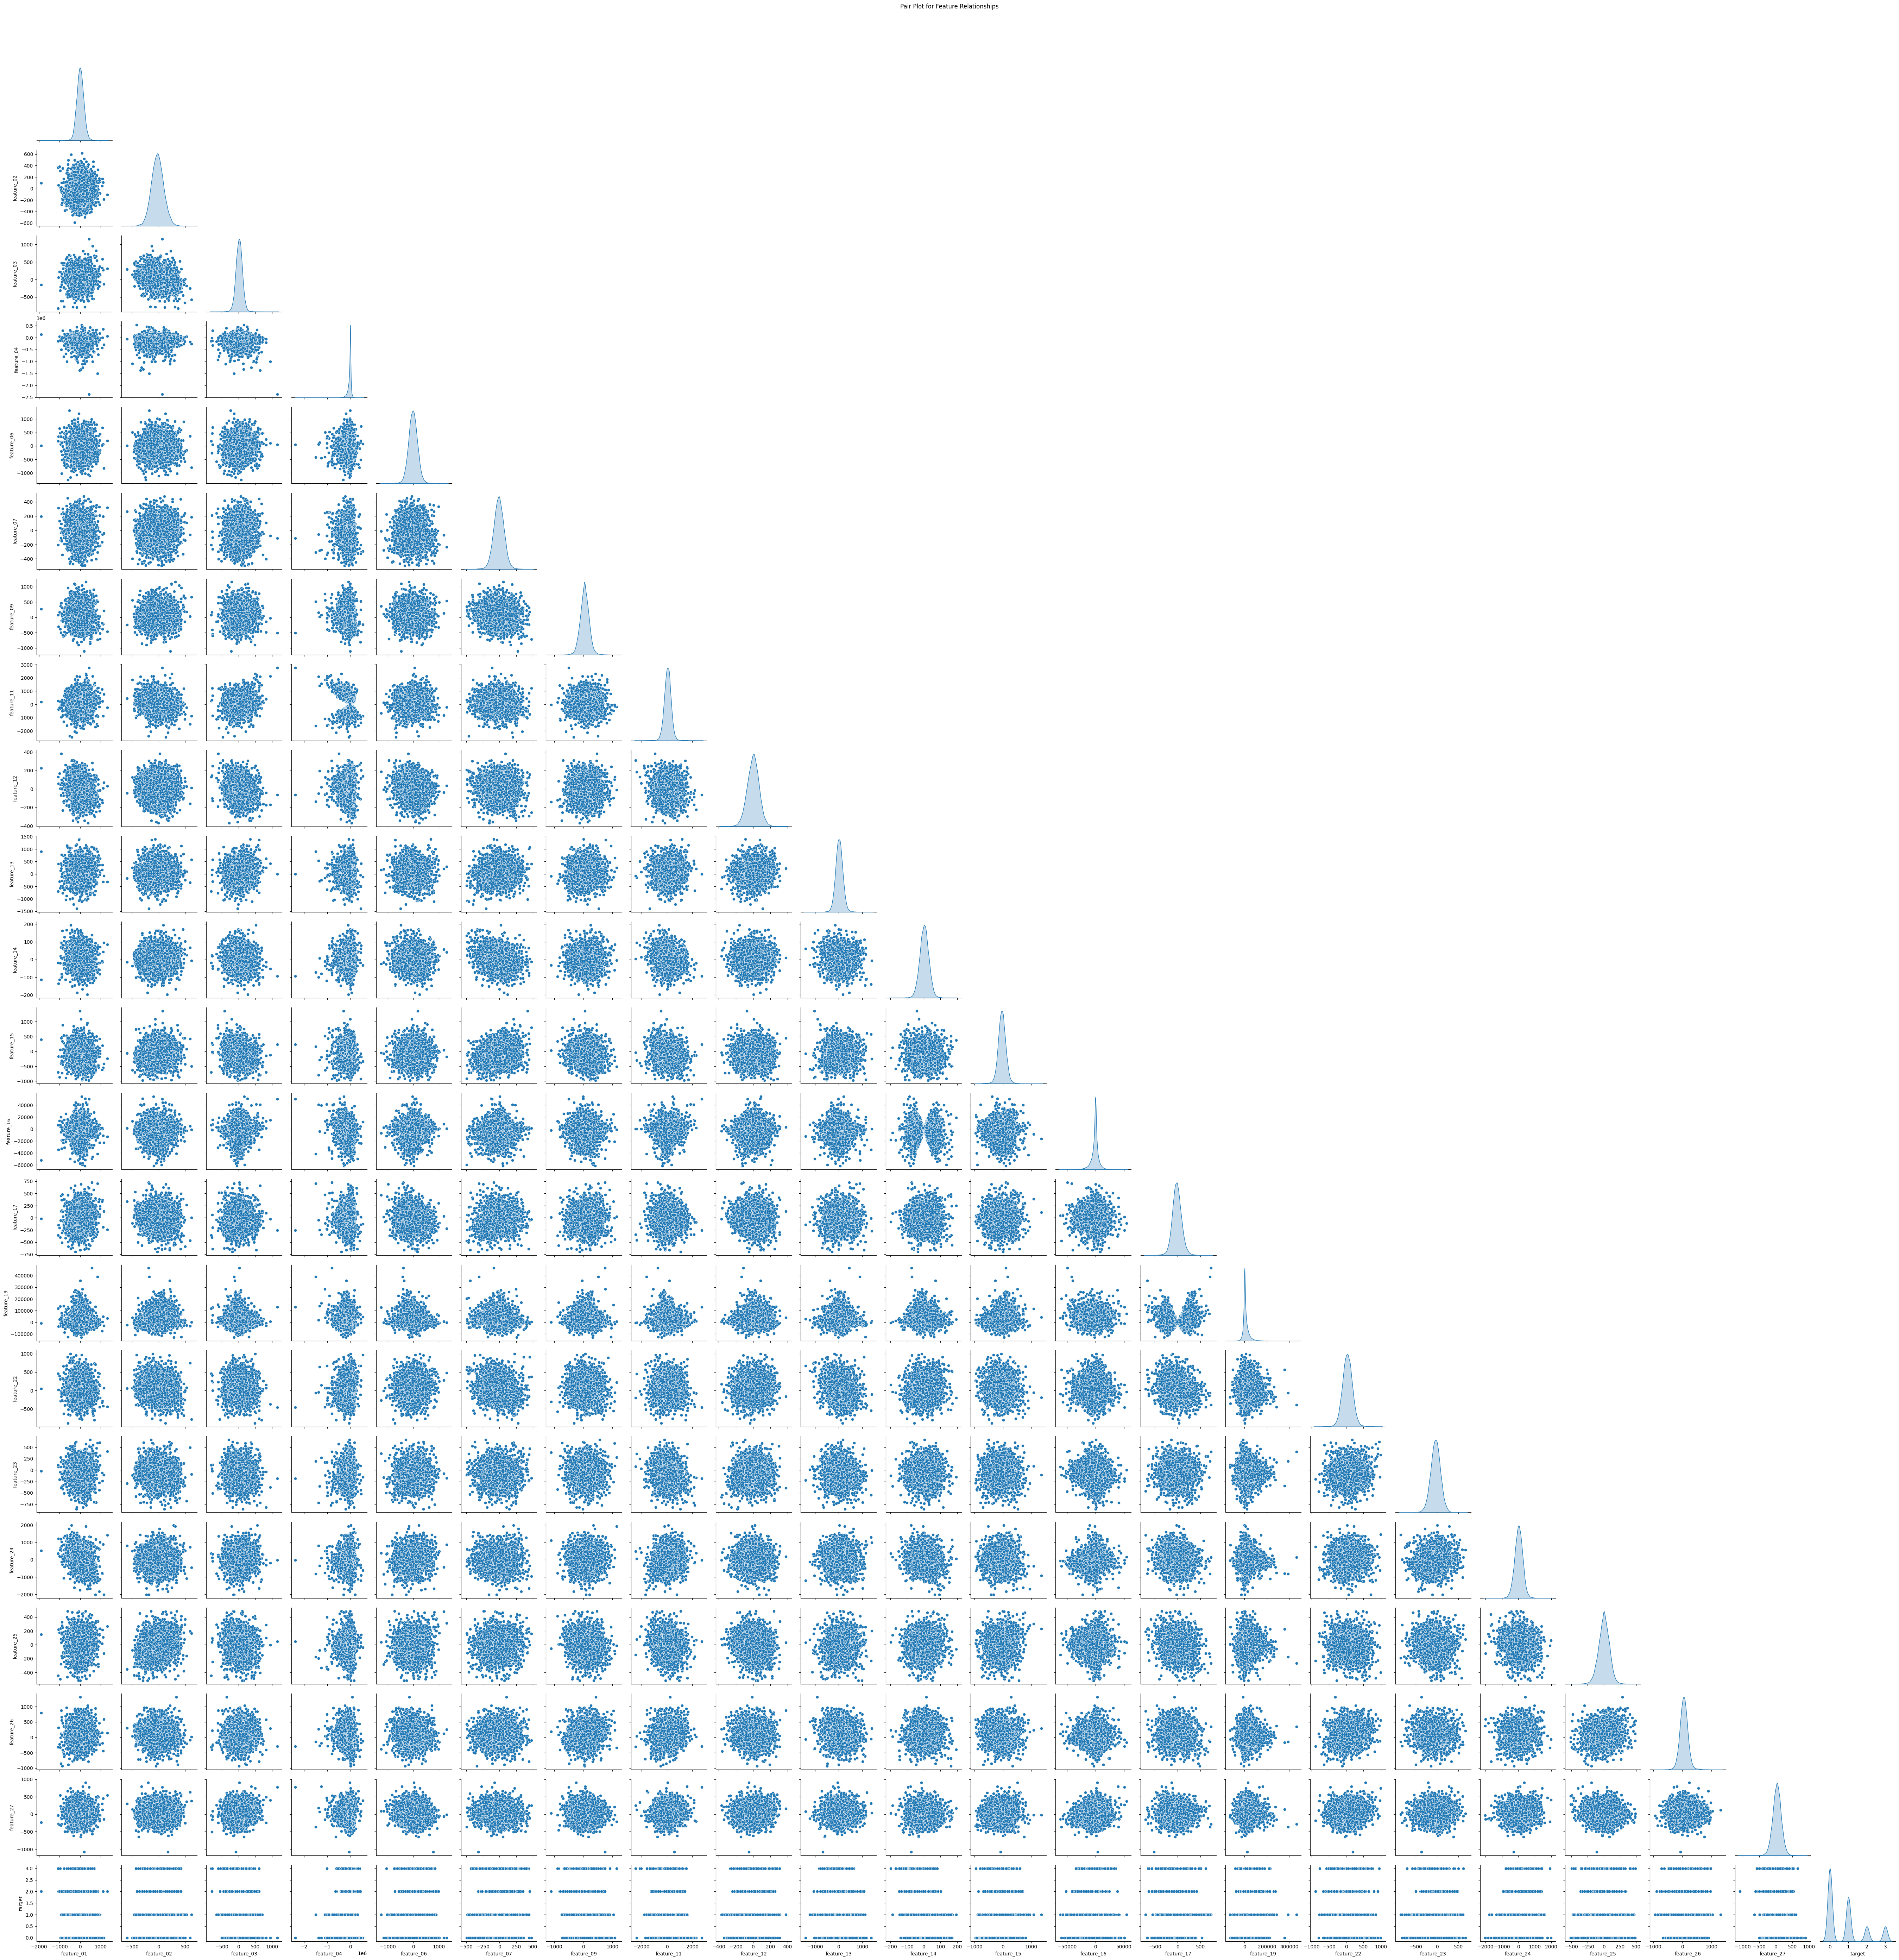

In [15]:
sns.pairplot(df_cleaned, diag_kind="kde", corner=True)
plt.suptitle("Pair Plot for Feature Relationships", y=1.02)
plt.show()

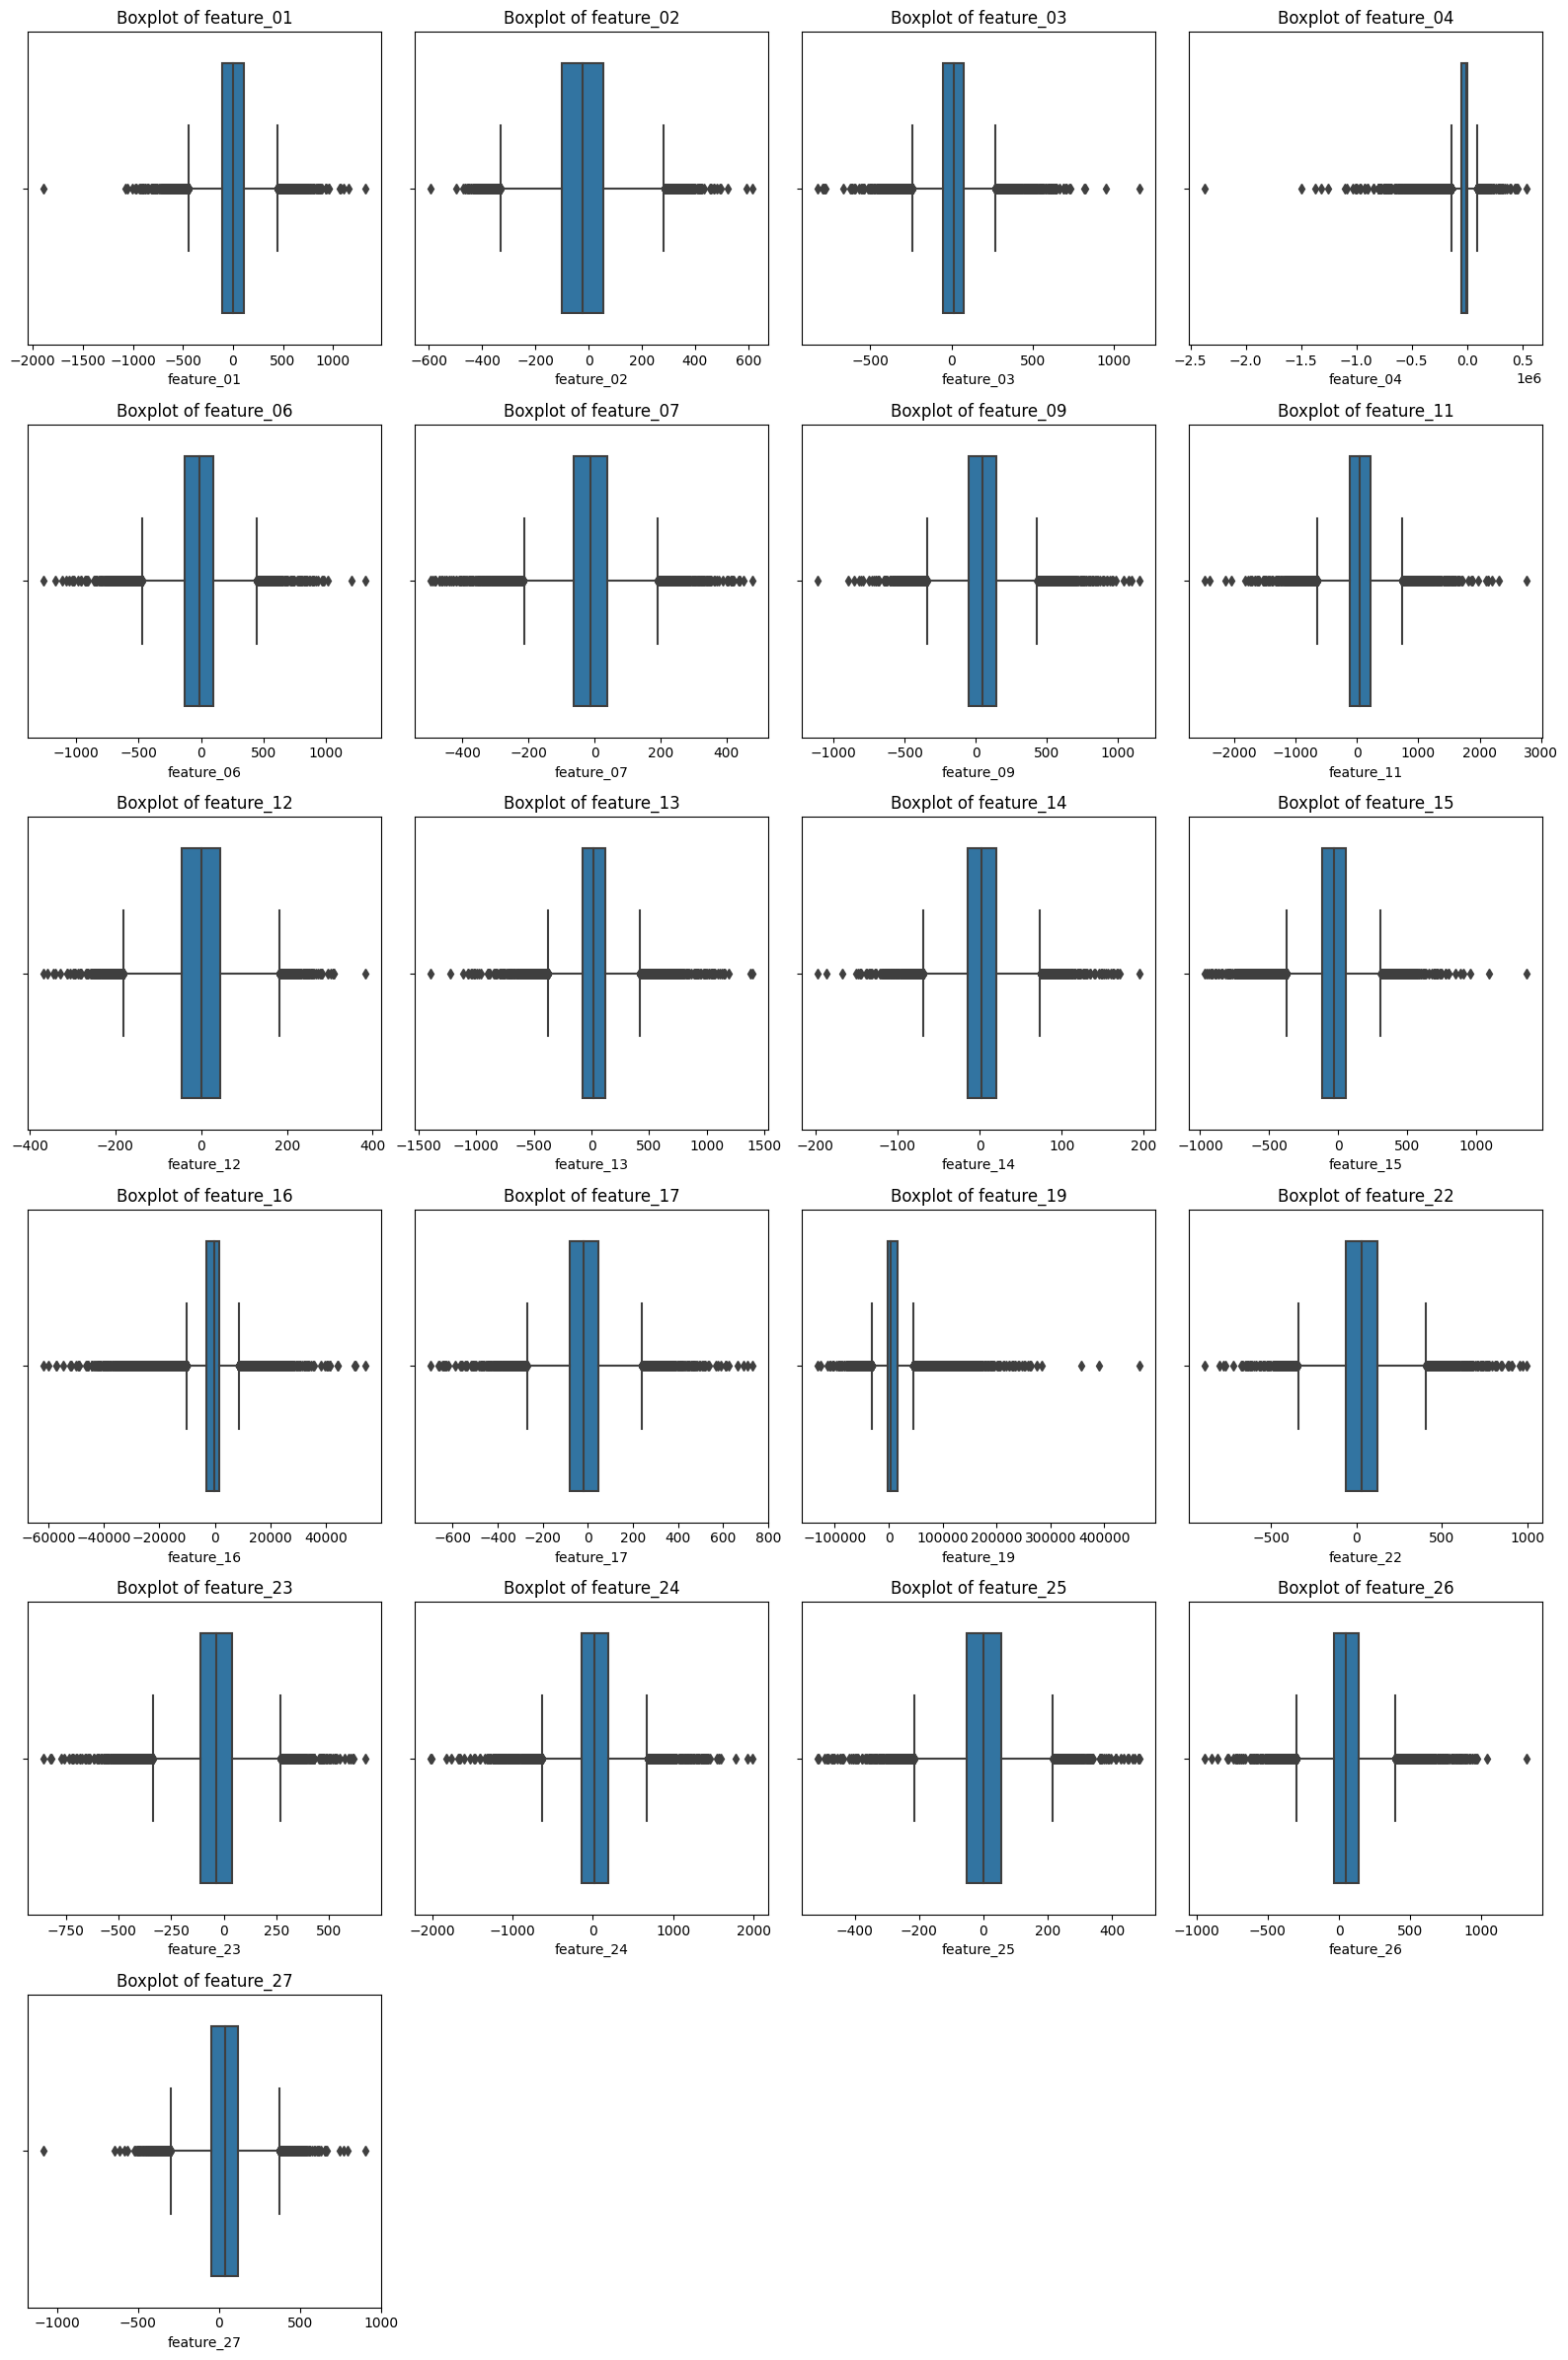

In [16]:
features = df_cleaned.drop(columns=['target']).columns

n_features = len(features)
n_cols = 4  
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))  
axes = axes.flatten()  

for i, column in enumerate(features):
    sns.boxplot(x=df_cleaned[column], ax=axes[i])
    axes[i].set_title(f"Boxplot of {column}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are a lot of outliers. Therefore, I will use Robust Scaling to handle the impact of outliers while normalizing the dataset. Unlike StandardScaler, which centers data around the mean and can be heavily influenced by extreme values, RobustScaler uses the median and interquartile range (IQR) for scaling. Moreover, I will apply a capping transformation to the outliers, further reducing the impact of extreme outliers

In [17]:
for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    if column != 'target':  # Skip the target column
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_cleaned[column] = df_cleaned[column].clip(lower=lower_bound, upper=upper_bound)



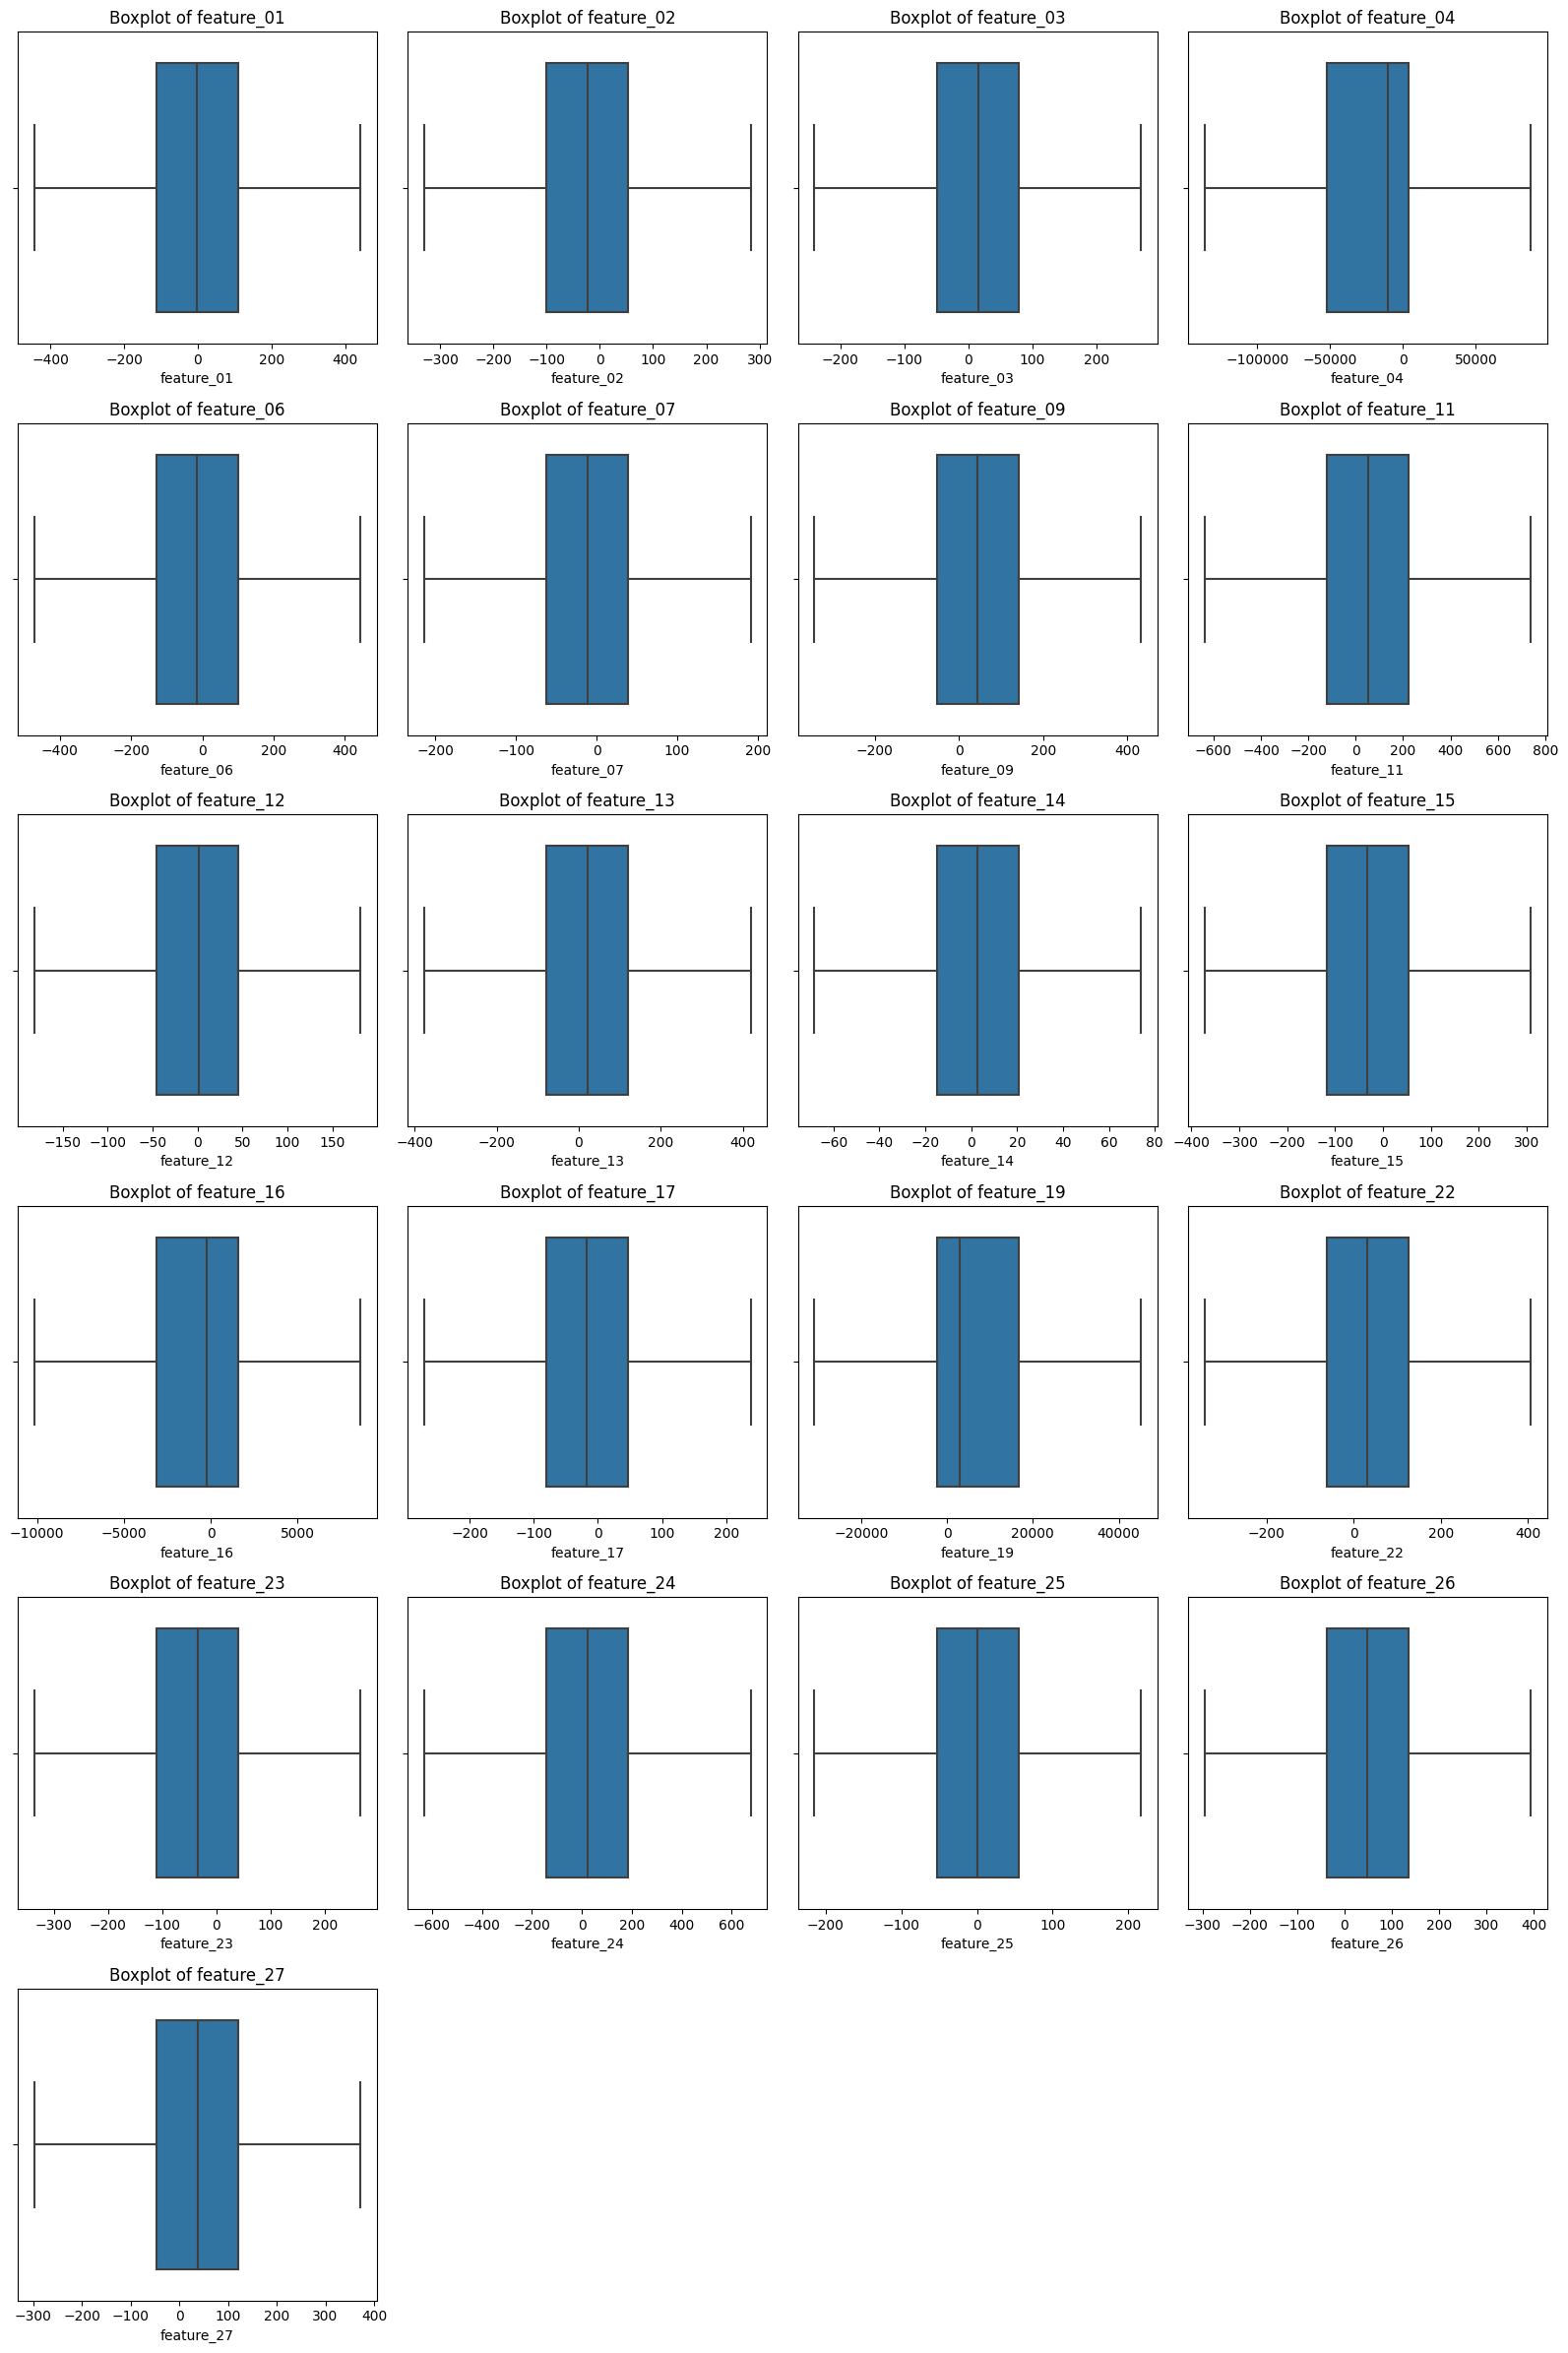

In [18]:
features = df_cleaned.drop(columns=['target']).columns

n_features = len(features)
n_cols = 4  
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))  
axes = axes.flatten()  

for i, column in enumerate(features):
    sns.boxplot(x=df_cleaned[column], ax=axes[i])
    axes[i].set_title(f"Boxplot of {column}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Machine Learning Algorithms and Classification

In [19]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_cleaned.drop(columns=['target']))
df_cleaned_scaled = pd.DataFrame(scaled_data, columns=df_cleaned.drop(columns=['target']).columns)
df_cleaned_scaled['target'] = df_cleaned['target']



In [20]:
from sklearn.model_selection import train_test_split

X = df_cleaned_scaled.drop(columns=['target'])
y = df_cleaned_scaled['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Validation set size: {X_valid.shape}")


Training set size: (28000, 21), Validation set size: (7000, 21)


## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)

print("Logistic Regression Validation Accuracy:", accuracy_score(y_valid, y_pred))

NameError: name 'accuracy_score' is not defined

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)

print("Random Forest Validation Accuracy:", accuracy_score(y_valid, y_pred))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=300, num=10)],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
    
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='accuracy',
    cv=3,  
    verbose=2,
    random_state=42,
    n_jobs=-1
    
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_valid)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report:")
print(classification_report(y_valid, y_pred))

In [ ]:
importance = best_rf.feature_importances_  

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': importance
})

importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance (Percentage)')
plt.gca().invert_yaxis()
plt.show()

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb = XGBClassifier(
    random_state=42,
    n_estimators=100,  
    learning_rate=0.1,  
    max_depth=6,  
    use_label_encoder=False,  
    eval_metric='mlogloss'  
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_valid)

print("XGBoost Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report for XGBoost:")
print(classification_report(y_valid, y_pred))


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)



grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
print("XGBoost with Best Parameters Validation Accuracy:", accuracy_score(y_valid, y_pred))


In [ ]:
from xgboost import plot_importance


importance = best_model.get_booster().get_score(importance_type='weight')  

importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
})

importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.title('Feature Importance (Percentage)')
plt.gca().invert_yaxis()
plt.show()

# Conclusion  

I ran two different models, and the dominant features in the feature importance graphs vary between the models. The interesting point is that **feature_01** has almost no correlation with any column, including the target, according to the correlation map. However, in the XGBoost model, it appears as the most important feature, and the distrubion of the importance of the feature is more equal in Xgboost model.

# Submission Part

In [ ]:
df_test = pd.read_csv('/kaggle/input/math482-2024-2025-1-hw-02-v2/test.csv')  

dropped_features = ['id','feature_05', 'feature_08', 'feature_20', 'feature_10', 'feature_18', 'feature_21'] 
df_test_cleaned = df_test.drop(columns=dropped_features, errors='ignore')

df_test_cleaned_scaled = scaler.transform(df_test_cleaned)  

y_test_pred = best_model.predict(df_test_cleaned_scaled)

In [ ]:
submission_xgb = pd.DataFrame({
    'id': df_test['id'],       
    'target': y_test_pred      
})

submission_xgb.to_csv('submission_xgb.csv', index=False)
print("Submission file created: submission_xgb.csv")